In [19]:
import pandas as pd
import csv
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [20]:
buy_behavior = pd.read_csv('buy_behavior_log.csv')
number_of_queries = buy_behavior.shape[0]
unique_brands = buy_behavior["brand"].unique()
unique_users = buy_behavior["user"].unique()

print(len(unique_brands))
print(len(unique_users))
print(number_of_queries)

buy_behavior.head(5)

206307
997816
9115919


,user,time_stamp,btag,cate,brand
0,916958,1493811673,buy,123,97176
1,916958,1493811809,buy,123,97176
2,628854,1493781424,buy,4262,370203
3,623496,1493810730,buy,4262,370203
4,1099015,1493774927,buy,9390,347564


In [21]:
user_profile = pd.read_csv('user_profile.csv')

user_profile.head(5)

,userid,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level
0,234,0,5,2,5,NaN,3,0,3.0
1,523,5,2,2,2,1.0,3,1,2.0
2,612,0,8,1,2,2.0,3,0,NaN
3,1670,0,4,2,4,NaN,1,0,NaN
4,2545,0,10,1,4,NaN,3,0,NaN


In [22]:
def analysis(data, sensitive_attribute_val, analysis_val):
    
    attribute_mapping = {1: 'final_gender_code', 2: 'age_level', 3: 'pvalue_level', 4: 'occupation'}
    sensitive_attribute = attribute_mapping[sensitive_attribute_val]
    
    brand_mapping = {1: 'brand', 2: 'brand_combined'}
    analysis_str = brand_mapping[analysis_val]
    
    # Group the merged dataframe by the 'brand' and 'pvalue_level' columns and get the count of each group
    grouped_df = data.groupby([analysis_str, sensitive_attribute], as_index=False).count()[[analysis_str, sensitive_attribute, 'user']]

    # Pivot the grouped dataframe to create a pivot table with the 'brand' column as the index, the 'pvalue_level' column as the columns and the 'user' column as the values
    pivot_table = grouped_df.pivot(index=analysis_str, columns=sensitive_attribute, values='user')
    pivot_table = pivot_table.fillna(0)
    
    # Get the total number of users for each gender
    brand_totals = pivot_table.sum(axis=1)

    # Divide the values in the pivot table by the gender totals and multiply by 100 to get the percent values
    percent_table = (pivot_table / brand_totals.values.reshape(-1, 1)) * 100
    percent_table = percent_table.fillna(0)
    percent_table = percent_table.round(2)

    # Find ambiguity value by subtracting max frequency from 100 in each row
    ambiguity_values = 100 - percent_table.max(axis=1)

    # Create new dataframe with brand and ambiguity value
    ambiguity_table = pd.DataFrame({analysis_str: percent_table.index, 'ambiguity': ambiguity_values.round(2)}).reset_index(drop=True)

    # Display the new dataframe

    amb_dict = dict(ambiguity_table['ambiguity'].value_counts())

    # Sort the dictionary items by their keys
    ambiguity_dict_attribute = dict(sorted(amb_dict.items(), key=lambda x: x[0]))

    ambiguity_users = {}

    for index, row in ambiguity_table.iterrows():
        brand = row[analysis_str]
        ambiguity_value = row['ambiguity']
        pivot_row = pivot_table.loc[brand]
        total_users = int(pivot_row.sum())

        if ambiguity_value in ambiguity_users:
            ambiguity_users[ambiguity_value] += total_users

        else:
            ambiguity_users[ambiguity_value] = total_users

    ambiguity_users = dict(sorted(ambiguity_users.items(), key=lambda x: x[0]))
    
    return pivot_table, ambiguity_dict_attribute, ambiguity_users

In [23]:
def count_users_ambiguity_less_than_one(ambiguity_user_values):
    count = 0
    for ambiguity_value, num_users in ambiguity_user_values.items():
        if ambiguity_value < 1.00:
            count += num_users
    return count


In [24]:
top_brands = buy_behavior['brand'].value_counts().head(10).index.tolist()
top_brands_data = buy_behavior[buy_behavior['brand'].isin(top_brands)]

number_of_queries = top_brands_data.shape[0]
unique_brands = top_brands_data["brand"].unique()
unique_users = top_brands_data["user"].unique()

print(len(unique_brands))
print(len(unique_users))
print(number_of_queries)

merged_data = pd.merge(top_brands_data, user_profile, left_on='user', right_on='userid')
# Drop the 'userid' column since it contains the same values as 'user'
merged_data = merged_data.drop('userid', axis=1)
merged_data.head(5)

brand_combinations = list(itertools.combinations(top_brands, 3))
print(len(brand_combinations))

10
449290
1116891
120


In [25]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

result_df = pd.DataFrame(columns=['age_level', 'final_gender_code', 'pvalue_level', 'occupation'])

for brand_combo in brand_combinations:
    brand1, brand2, brand3 = brand_combo
    brand_data = merged_data[(merged_data['brand']==brand1) & 
                             (merged_data['user'].isin(merged_data[merged_data['brand']==brand2]['user'].tolist())) &
                             (merged_data['user'].isin(merged_data[merged_data['brand']==brand3]['user'].tolist()))]
    brand_data['brand_combined'] = str(brand1) + '_' + str(brand2) + '_' + str(brand3)
    user_data = brand_data[['user', 'brand_combined', 'age_level', 'final_gender_code', 'pvalue_level', 'occupation']]
    result_df = result_df.append(user_data, ignore_index=True)
    
result_df = result_df.drop_duplicates(keep='first')
print(result_df)

      age_level final_gender_code  pvalue_level occupation       user  \
0             4                 1           1.0          0   872106.0   
3             3                 1           NaN          0   120144.0   
4             2                 2           2.0          0   208103.0   
5             3                 2           NaN          0  1093588.0   
6             3                 2           NaN          0    10851.0   
...         ...               ...           ...        ...        ...   
45075         3                 2           2.0          0   549328.0   
45076         3                 1           NaN          0  1043345.0   
45077         5                 1           NaN          0   889630.0   
45078         5                 1           NaN          0  1083413.0   
45080         1                 2           NaN          0   744672.0   

             brand_combined  
0      370203_388700_247789  
3      370203_388700_247789  
4      370203_388700_247789  
5  

In [26]:
#### Gender analysis for three brand combinations #####

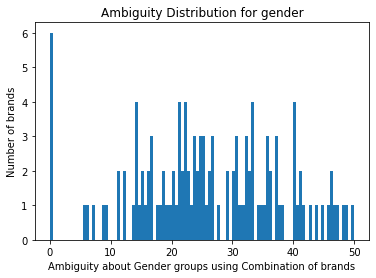

In [27]:
pivot_table_gender, ambiguity_dict_gender, ambiguity_users_gender = analysis(result_df, 1, 2)
x_values = list(ambiguity_dict_gender.keys())
y_values = list(ambiguity_dict_gender.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Gender groups using Combination of brands')
plt.ylabel('Number of brands')
plt.title('Ambiguity Distribution for gender')

# Show the plot
plt.show()

41


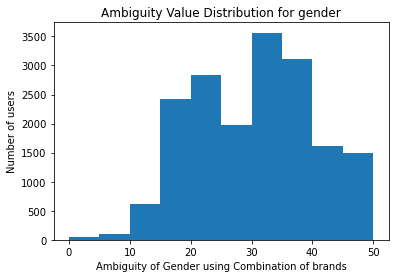

In [28]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_gender.keys())
y_values = list(ambiguity_users_gender.values())
print(count_users_ambiguity_less_than_one(ambiguity_users_gender))

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Gender using Combination of brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for gender')
plt.show()

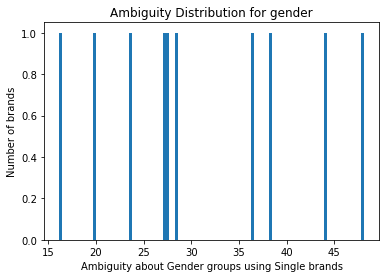

In [29]:
pivot_table_gender, ambiguity_dict_gender, ambiguity_users_gender = analysis(merged_data, 1, 1)
x_values = list(ambiguity_dict_gender.keys())
y_values = list(ambiguity_dict_gender.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Gender groups using Single brands')
plt.ylabel('Number of brands')
plt.title('Ambiguity Distribution for gender')

# Show the plot
plt.show()

0


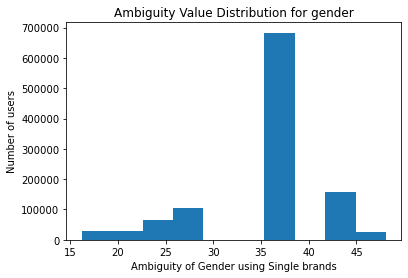

In [30]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_gender.keys())
y_values = list(ambiguity_users_gender.values())
print(count_users_ambiguity_less_than_one(ambiguity_users_gender))

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Gender using Single brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for gender')
plt.show()

In [31]:
#### Age analysis #####

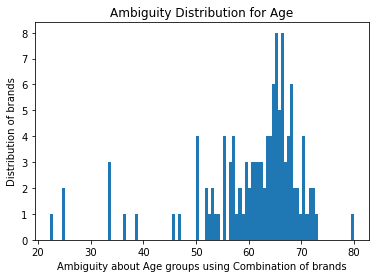

In [32]:
pivot_table_age, ambiguity_dict_age, ambiguity_users_age = analysis(result_df, 2, 2)
x_values = list(ambiguity_dict_age.keys())
y_values = list(ambiguity_dict_age.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Age groups using Combination of brands')
plt.ylabel('Distribution of brands')
plt.title('Ambiguity Distribution for Age')

# Show the plot
plt.show()

0


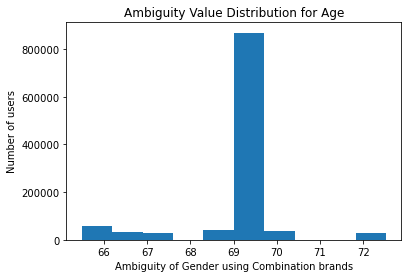

In [46]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_age.keys())
y_values = list(ambiguity_users_age.values())
print(count_users_ambiguity_less_than_one(ambiguity_users_age))

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Gender using Combination brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for Age')
plt.show()

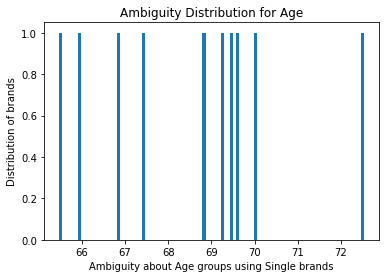

In [34]:
pivot_table_age, ambiguity_dict_age, ambiguity_users_age = analysis(merged_data, 2, 1)
x_values = list(ambiguity_dict_age.keys())
y_values = list(ambiguity_dict_age.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Age groups using Single brands')
plt.ylabel('Distribution of brands')
plt.title('Ambiguity Distribution for Age')

# Show the plot
plt.show()

0


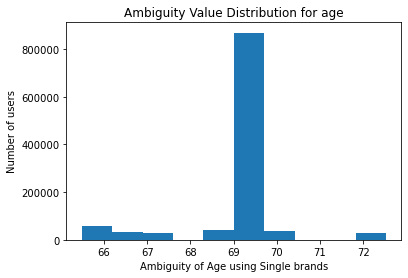

In [35]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_age.keys())
y_values = list(ambiguity_users_age.values())
print(count_users_ambiguity_less_than_one(ambiguity_users_age))

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Age using Single brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for age')
plt.show()

In [36]:
#### pvalue analysis #####

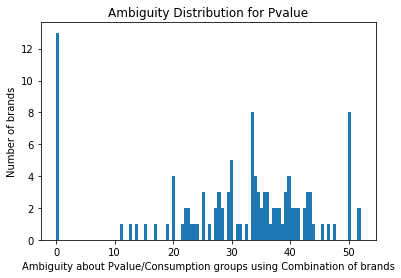

In [48]:
pivot_table_pval, ambiguity_dict_pval, ambiguity_users_pval = analysis(result_df, 3, 2)
x_values = list(ambiguity_dict_pval.keys())
y_values = list(ambiguity_dict_pval.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Pvalue/Consumption groups using Combination of brands')
plt.ylabel('Number of brands')
plt.title('Ambiguity Distribution for Pvalue')

# Show the plot
plt.show()


40


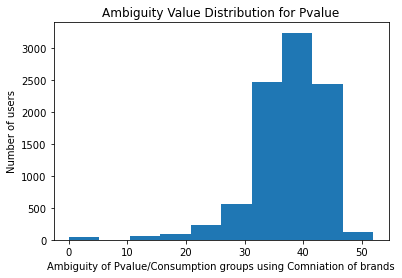

In [49]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_pval.keys())
y_values = list(ambiguity_users_pval.values())
print(count_users_ambiguity_less_than_one(ambiguity_users_pval))

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Pvalue/Consumption groups using Comniation of brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for Pvalue')
plt.show()

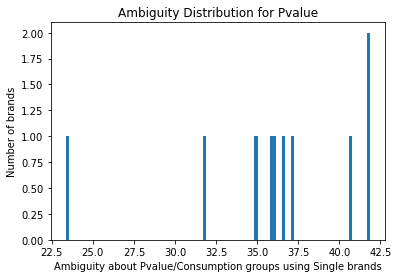

In [50]:
pivot_table_pval, ambiguity_dict_pval, ambiguity_users_pval = analysis(merged_data, 3, 1)
x_values = list(ambiguity_dict_pval.keys())
y_values = list(ambiguity_dict_pval.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Pvalue/Consumption groups using Single brands')
plt.ylabel('Number of brands')
plt.title('Ambiguity Distribution for Pvalue')

# Show the plot
plt.show()

0


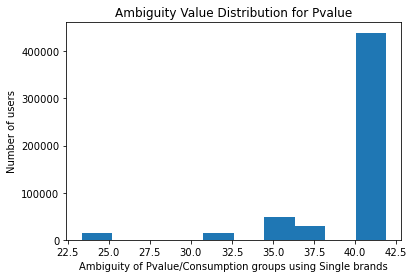

In [51]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_pval.keys())
y_values = list(ambiguity_users_pval.values())
print(count_users_ambiguity_less_than_one(ambiguity_users_pval))

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Pvalue/Consumption groups using Single brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for Pvalue')
plt.show()

In [52]:
#### Occupation analysis ####

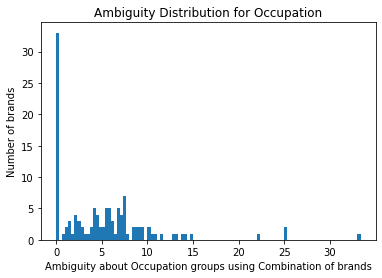

In [53]:
###### occupation ######
# Is the college student 1: yes, 0: no?

pivot_table_occup, ambiguity_dict_occup, ambiguity_users_occup = analysis(result_df, 4, 2)
x_values = list(ambiguity_dict_occup.keys())
y_values = list(ambiguity_dict_occup.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Occupation groups using Combination of brands')
plt.ylabel('Number of brands')
plt.title('Ambiguity Distribution for Occupation')

# Show the plot
plt.show()

785


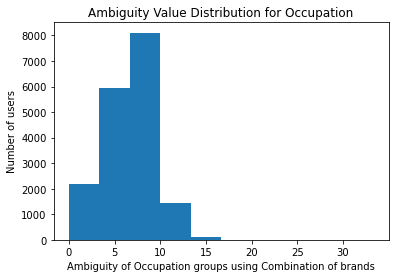

In [54]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_occup.keys())
y_values = list(ambiguity_users_occup.values())
print(count_users_ambiguity_less_than_one(ambiguity_users_occup))

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Occupation groups using Combination of brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for Occupation')
plt.show()

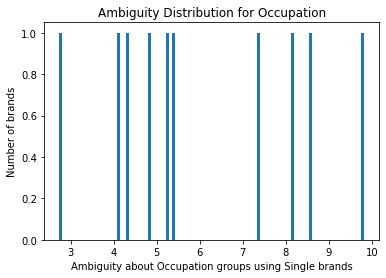

In [55]:
###### occupation ######
# Is the college student 1: yes, 0: no?

pivot_table_occup, ambiguity_dict_occup, ambiguity_users_occup = analysis(merged_data, 4, 1)
x_values = list(ambiguity_dict_occup.keys())
y_values = list(ambiguity_dict_occup.values())

# Create a histogram with 10 bins
plt.hist(x_values, bins=100, weights=y_values)

# Add axis labels and a title
plt.xlabel('Ambiguity about Occupation groups using Single brands')
plt.ylabel('Number of brands')
plt.title('Ambiguity Distribution for Occupation')

# Show the plot
plt.show()

0


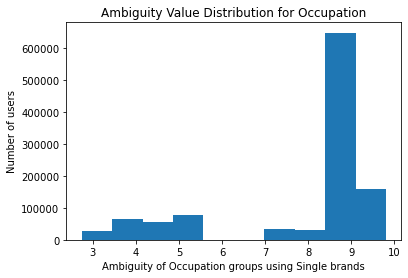

In [56]:
# `ambiguity_dict` is the sorted dictionary you created earlier
x_values = list(ambiguity_users_occup.keys())
y_values = list(ambiguity_users_occup.values())
print(count_users_ambiguity_less_than_one(ambiguity_users_occup))

# Create a histogram with 10 bins
plt.hist(x_values, bins=10, weights=y_values)

plt.xlabel('Ambiguity of Occupation groups using Single brands')
plt.ylabel('Number of users')
plt.title('Ambiguity Value Distribution for Occupation')
plt.show()